In [1]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import scipy.constants as const
import astropy.constants as aconst
from pycbc import fft
from pycbc.filter import match, overlap_cplx, sigma, sigmasq, make_frequency_series
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.waveform import taper_timeseries
from pycbc.types import timeseries, frequencyseries, zeros, complex_same_precision_as
from calcwf import *

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


# 24 chirp mass

In [14]:
# Load data
with open(os.path.join('harmonic_overlaps_data', 'dataslot_4', 'all_matches'), 'rb') as fp:
    data = pickle.load(fp)

fid_chirp = list(data.keys())[1]
fid_e = list(data[fid_chirp].keys())[1]

# Calculate degeneracy lines
sparse_e_vals = np.linspace(data[fid_chirp][fid_e]['e_vals'][0], data[fid_chirp][fid_e]['e_vals'][-1], 31)
init_guess = fid_chirp
sample_rate = data[fid_chirp][fid_e]['fid_params']['sample_rate']
f_low = data[fid_chirp][fid_e]['fid_params']['f_low']
q = data[fid_chirp][fid_e]['fid_params']['q']
min_func = lambda x: abs(chirp_degeneracy_line(x, fid_e, sample_rate=sample_rate, f_low=f_low, q=q) - fid_chirp)
zero_ecc_chirp_mass = minimize(min_func, init_guess)['x']
sparse_chirp_vals = chirp_degeneracy_line(zero_ecc_chirp_mass, sparse_e_vals, sample_rate=sample_rate, f_low=f_low, q=q)

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other


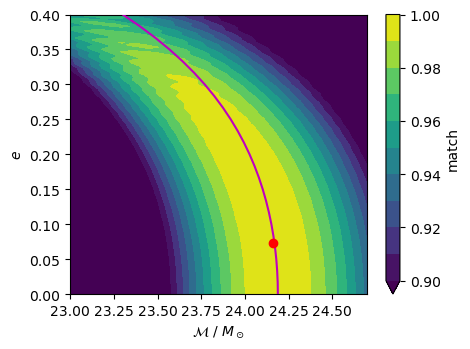

In [15]:
key = 'h0'

# Plot grid
plt.figure(figsize=(0.75*6.4,0.75*4.8))
plt.contourf(data[fid_chirp][fid_e]['chirp_vals'], data[fid_chirp][fid_e]['e_vals'], data[fid_chirp][fid_e][key], np.linspace(0.9, 1, 11), vmax=1, vmin=0.9, extend='min')
plt.colorbar(label='match')
plt.scatter(fid_chirp, fid_e, c='r', zorder=5)
xlims = plt.gca().get_xlim()
ylims = plt.gca().get_ylim()

# Plot degeneracy lines
plt.plot(sparse_chirp_vals, sparse_e_vals, c='m', label='full', zorder=3)

# Plot formatting
plt.ylim(ylims[0], 0.4)
plt.xlim(23, xlims[1])
plt.xlabel('$\mathcal{M}~/~M_\odot$')
plt.ylabel('$e$')

plt.tight_layout()
plt.savefig('Figures/ho_standalone.png', dpi=450)

/tmp/ipykernel_2819379/1476981191.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


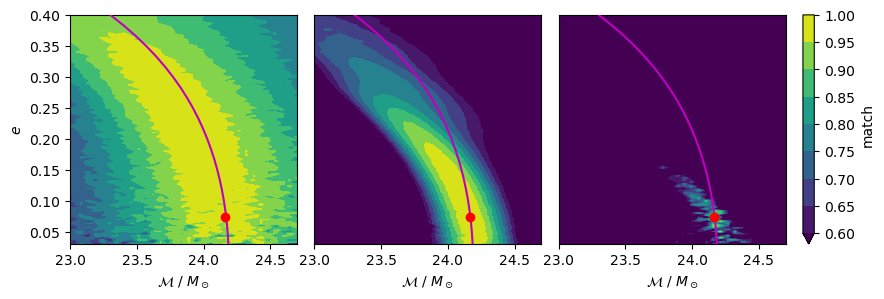

In [16]:
# Plot each grid
keys = ['h-1', 'h1', 'h2']
fig, axs = plt.subplots(ncols=4,figsize=(1.5*6.4, 0.62*4.8), gridspec_kw={'width_ratios':[1,1,1,0.05], 'wspace': 0.1})
for i in range(3):
    key = keys[i]

    # Plot grid
    contours = axs[i].contourf(data[fid_chirp][fid_e]['chirp_vals'], data[fid_chirp][fid_e]['e_vals'], data[fid_chirp][fid_e][key], np.linspace(0.6, 1, 9), vmax=1, vmin=0.6, extend='min')
    axs[i].scatter(fid_chirp, fid_e, c='r', zorder=5)
    xlims = axs[i].get_xlim()

    # Plot degeneracy lines
    axs[i].plot(sparse_chirp_vals, sparse_e_vals, c='m', label='full', zorder=3)

    # Plot formatting
    axs[i].set_ylim(0.03, 0.4)
    axs[i].set_xlim(23, xlims[1])
    axs[i].set_xlabel('$\mathcal{M}~/~M_\odot$')
    axs[i].set_ylabel('$e$')
    if i > 0:
        axs[i].get_yaxis().set_visible(False)
fig.colorbar(contours, cax=axs[-1], label='match')
plt.tight_layout()
plt.savefig('Figures/ho_harms.png', dpi=450, bbox_inches='tight')

# Poster plot

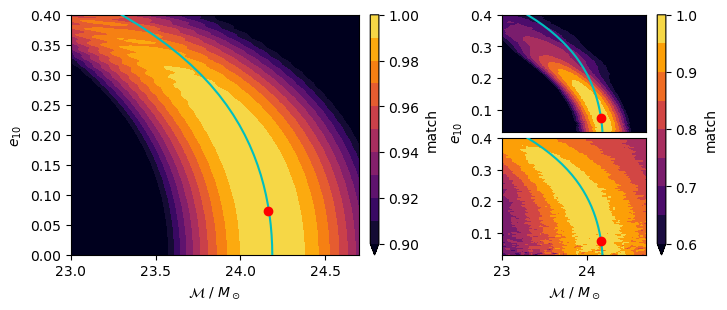

In [88]:
fig, subaxs = plt.subplots(nrows=2, ncols=5, figsize=(1.2*6.4, 0.65*4.8), gridspec_kw={'width_ratios':[1,0.03,0.35,0.5,0.03], 'wspace': 0.1, 'height_ratios':[1,1], 'hspace': 0.05})

# Join all but 3rd column
axs = [None, None, None, None, None]
for i in [0,1,2,4]:
    gs = subaxs[0, i].get_gridspec()
    for ax in subaxs[:, i]:
        ax.remove()
    if i != 2:
        axs[i] = fig.add_subplot(gs[:, i])
axs[3] = [subaxs[0,3], subaxs[1,3]]

# Setup h0 cmap
cmap = mpl.colormaps['inferno']
colors = cmap([np.linspace(0,0.9,11)])[0]
colors[0] = mpl.colors.to_rgba('#00001E')

# Plot h0
contours = axs[0].contourf(data[fid_chirp][fid_e]['chirp_vals'], data[fid_chirp][fid_e]['e_vals'], data[fid_chirp][fid_e]['h0'], np.linspace(0.9, 1, 11), vmax=1, vmin=0.9, extend='min', colors=colors)
axs[0].scatter(fid_chirp, fid_e, c='r', zorder=5)
xlims = axs[0].get_xlim()

# Plot degeneracy lines
axs[0].plot(sparse_chirp_vals, sparse_e_vals, c='c', label='full', zorder=3)

# Plot formatting
axs[0].set_ylim(0, 0.4)
axs[0].set_xlim(23, xlims[1])
axs[0].set_xlabel('$\mathcal{M}~/~M_\odot$')
axs[0].set_ylabel('$e_{10}$')
fig.colorbar(contours, cax=axs[1], label='match')

# Setup h1 and h-1 cmap
cmap = mpl.colormaps['inferno']
colors = cmap([np.linspace(0,0.9,9)])[0]
colors[0] = mpl.colors.to_rgba('#00001E')

# Plot h1 and h-1
keys = ['h1', 'h-1']
for i in range(2):
    
    # Plot contours
    contours = axs[3][i].contourf(data[fid_chirp][fid_e]['chirp_vals'], data[fid_chirp][fid_e]['e_vals'], data[fid_chirp][fid_e][keys[i]], np.linspace(0.6, 1, 9), vmax=1, vmin=0.6, extend='min', colors=colors)
    axs[3][i].scatter(fid_chirp, fid_e, c='r', zorder=5)
    xlims = axs[3][i].get_xlim()
    
    # Plot degeneracy lines
    axs[3][i].plot(sparse_chirp_vals, sparse_e_vals, c='c', label='full', zorder=3)
    
    # Plot formatting
    axs[3][i].set_ylim(0.03, 0.4)
    axs[3][i].set_xlim(23, xlims[1])
    if i == 0:
        axs[3][i].get_xaxis().set_visible(False)
    else:
        axs[3][i].set_xlabel('$\mathcal{M}~/~M_\odot$')
        axs[3][i].set_ylabel('$e_{10}$', y=1.05)
fig.colorbar(contours, cax=axs[4], label='match', ticks=np.linspace(0.6,1,5))

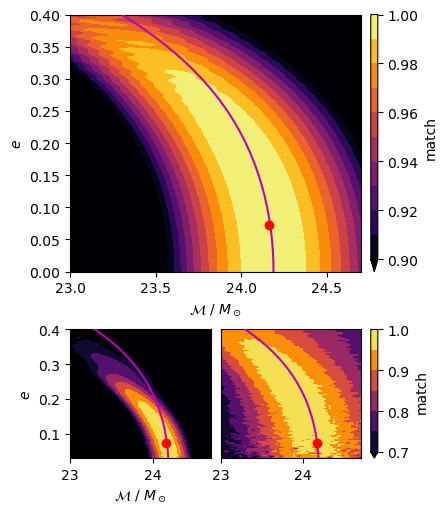

In [76]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(0.62*6.4, 1.2*4.8), gridspec_kw={'width_ratios':[1,1,0.05], 'wspace': 0.1, 'height_ratios':[2,1], 'hspace': 0.3})

# Join h0 plot
gs = axs[0, 0].get_gridspec()
for ax in axs[0, :2]:
    ax.remove()
axs_h0 = fig.add_subplot(gs[0, :2])

# Plot h0
contours = axs_h0.contourf(data[fid_chirp][fid_e]['chirp_vals'], data[fid_chirp][fid_e]['e_vals'], data[fid_chirp][fid_e]['h0'], np.linspace(0.9, 1, 11), vmax=1, vmin=0.9, extend='min', cmap='inferno')
axs_h0.scatter(fid_chirp, fid_e, c='r', zorder=5)
xlims = axs_h0.get_xlim()

# Plot degeneracy lines
axs_h0.plot(sparse_chirp_vals, sparse_e_vals, c='m', label='full', zorder=3)

# Plot formatting
axs_h0.set_ylim(0, 0.4)
axs_h0.set_xlim(23, xlims[1])
axs_h0.set_xlabel('$\mathcal{M}~/~M_\odot$')
axs_h0.set_ylabel('$e$')
fig.colorbar(contours, cax=axs[0,2], label='match')

# Plot h1 and h-1
keys = ['h1', 'h-1']
for i in range(2):
    
    # Plot contours
    contours = axs[1][i].contourf(data[fid_chirp][fid_e]['chirp_vals'], data[fid_chirp][fid_e]['e_vals'], data[fid_chirp][fid_e][keys[i]], np.linspace(0.7, 1, 7), vmax=1, vmin=0.7, extend='min', cmap='inferno')
    axs[1][i].scatter(fid_chirp, fid_e, c='r', zorder=5)
    xlims = axs[1][i].get_xlim()
    
    # Plot degeneracy lines
    axs[1][i].plot(sparse_chirp_vals, sparse_e_vals, c='m', label='full', zorder=3)
    
    # Plot formatting
    axs[1][i].set_ylim(0.03, 0.4)
    axs[1][i].set_xlim(23, xlims[1])
    if i == 0:
        axs[1][i].set_xlabel('$\mathcal{M}~/~M_\odot$')
        axs[1][i].set_ylabel('$e$')
    else:
        axs[1][i].get_yaxis().set_visible(False)
fig.colorbar(contours, cax=axs[1][2], label='match', ticks=np.linspace(0.8,1,5))

# 10 chirp mass

In [23]:
# Load data
with open(os.path.join('harmonic_overlaps_data', 'dataslot_4', 'all_matches'), 'rb') as fp:
    data = pickle.load(fp)

fid_chirp = list(data.keys())[0]
fid_e = list(data[fid_chirp].keys())[0]

# Calculate degeneracy lines
sparse_e_vals = np.linspace(data[fid_chirp][fid_e]['e_vals'][0], data[fid_chirp][fid_e]['e_vals'][-1], 31)
init_guess = fid_chirp
sample_rate = data[fid_chirp][fid_e]['fid_params']['sample_rate']
f_low = data[fid_chirp][fid_e]['fid_params']['f_low']
q = data[fid_chirp][fid_e]['fid_params']['q']
min_func = lambda x: abs(chirp_degeneracy_line(x, fid_e, sample_rate=sample_rate, f_low=f_low, q=q) - fid_chirp)
zero_ecc_chirp_mass = minimize(min_func, init_guess)['x']
sparse_chirp_vals = chirp_degeneracy_line(zero_ecc_chirp_mass, sparse_e_vals, sample_rate=sample_rate, f_low=f_low, q=q)

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other


/tmp/ipykernel_2819379/1171296144.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


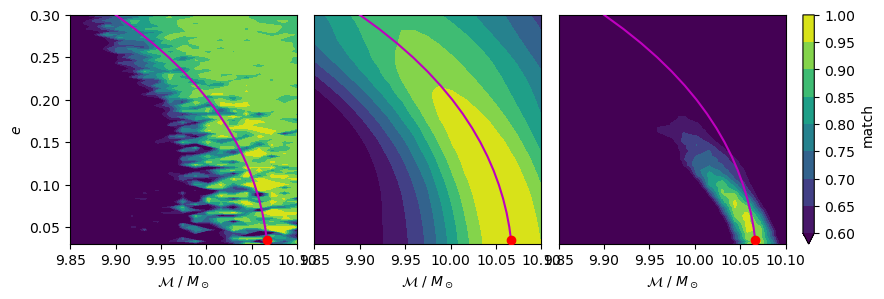

In [25]:
# Plot each grid
keys = ['h-1', 'h0', 'h1']
fig, axs = plt.subplots(ncols=4,figsize=(1.5*6.4, 0.62*4.8), gridspec_kw={'width_ratios':[1,1,1,0.05], 'wspace': 0.1})
for i in range(3):
    key = keys[i]

    # Plot grid
    contours = axs[i].contourf(data[fid_chirp][fid_e]['chirp_vals'], data[fid_chirp][fid_e]['e_vals'], data[fid_chirp][fid_e][key], np.linspace(0.6, 1, 9), vmax=1, vmin=0.6, extend='min')
    axs[i].scatter(fid_chirp, fid_e, c='r', zorder=5)
    xlims = axs[i].get_xlim()

    # Plot degeneracy lines
    axs[i].plot(sparse_chirp_vals, sparse_e_vals, c='m', label='full', zorder=3)

    # Plot formatting
    axs[i].set_ylim(0.03, 0.3)
    axs[i].set_xlim(9.85, 10.1)
    axs[i].set_xlabel('$\mathcal{M}~/~M_\odot$')
    axs[i].set_ylabel('$e$')
    if i > 0:
        axs[i].get_yaxis().set_visible(False)
fig.colorbar(contours, cax=axs[-1], label='match')
plt.tight_layout()
plt.savefig('Figures/ho_harms_10.png', dpi=450, bbox_inches='tight')

# 40 chirp mass

In [19]:
# Load data
with open(os.path.join('harmonic_overlaps_data', 'dataslot_4', 'all_matches'), 'rb') as fp:
    data = pickle.load(fp)

fid_chirp = list(data.keys())[2]
fid_e = list(data[fid_chirp].keys())[2]

# Calculate degeneracy lines
sparse_e_vals = np.linspace(data[fid_chirp][fid_e]['e_vals'][0], data[fid_chirp][fid_e]['e_vals'][-1], 31)
init_guess = fid_chirp
sample_rate = data[fid_chirp][fid_e]['fid_params']['sample_rate']
f_low = data[fid_chirp][fid_e]['fid_params']['f_low']
q = data[fid_chirp][fid_e]['fid_params']['q']
min_func = lambda x: abs(chirp_degeneracy_line(x, fid_e, sample_rate=sample_rate, f_low=f_low, q=q) - fid_chirp)
zero_ecc_chirp_mass = minimize(min_func, init_guess)['x']
sparse_chirp_vals = chirp_degeneracy_line(zero_ecc_chirp_mass, sparse_e_vals, sample_rate=sample_rate, f_low=f_low, q=q)

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other


/tmp/ipykernel_2819379/895537639.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


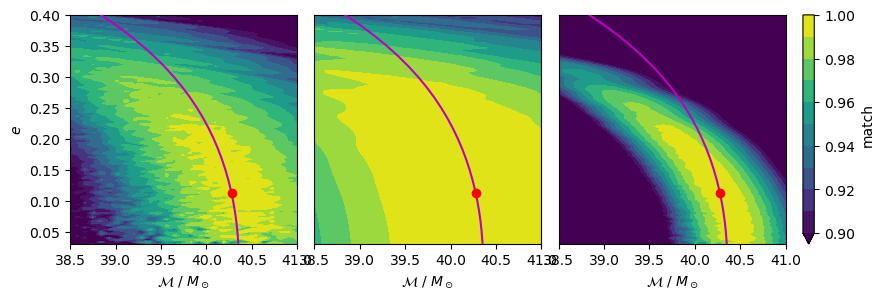

In [21]:
# Plot each grid
keys = ['h-1', 'h0', 'h1']
fig, axs = plt.subplots(ncols=4,figsize=(1.5*6.4, 0.62*4.8), gridspec_kw={'width_ratios':[1,1,1,0.05], 'wspace': 0.1})
for i in range(3):
    key = keys[i]

    # Plot grid
    contours = axs[i].contourf(data[fid_chirp][fid_e]['chirp_vals'], data[fid_chirp][fid_e]['e_vals'], data[fid_chirp][fid_e][key], np.linspace(0.9, 1, 11), vmax=1, vmin=0.9, extend='min')
    axs[i].scatter(fid_chirp, fid_e, c='r', zorder=5)
    xlims = axs[i].get_xlim()

    # Plot degeneracy lines
    axs[i].plot(sparse_chirp_vals, sparse_e_vals, c='m', label='full', zorder=3)

    # Plot formatting
    axs[i].set_ylim(0.03, 0.4)
    axs[i].set_xlim(38.5, 41)
    axs[i].set_xlabel('$\mathcal{M}~/~M_\odot$')
    axs[i].set_ylabel('$e$')
    if i > 0:
        axs[i].get_yaxis().set_visible(False)
fig.colorbar(contours, cax=axs[-1], label='match')
plt.tight_layout()
plt.savefig('Figures/ho_harms_40.png', dpi=450, bbox_inches='tight')